In [ ]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from fuzzywuzzy import fuzz, process
import re
from statsmodels.stats.outliers_influence import variance_inflation_factor

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV
from sklearn.linear_model import lars_path

from sklearn.linear_model import LinearRegression  
from yellowbrick.regressor import ResidualsPlot, CooksDistance

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import numpy as np
from sklearn.model_selection import train_test_split
import shap
from sklearn.preprocessing import StandardScaler

from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier

sns.set()
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression, LassoCV, RidgeCV, ElasticNetCV

In [3]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import seaborn as sns

In [85]:
def plot_act_vs_pred(y_act, y_pred, scale=1, act_label='actual', pred_label='predicted', figsize=None, xlim=None,
                     ylim=None, font=None):
    
    if font is not None:
        mpl.rc('font', **font)

    if figsize is not None:
        plt.figure(figsize=figsize)
    else:
        plt.figure(figsize=(10, 6))
    plt.scatter(y_act/scale, y_pred/scale)
    x = np.linspace(0, y_act.max()/scale, 10)
    plt.plot(x, x)
    plt.xlabel(act_label)
    plt.ylabel(pred_label)
    if xlim is not None:
        plt.xlim(xlim)
    else:
        plt.xlim([0, 1e2])
    if ylim is not None:
        plt.ylim(ylim)
    else:
        plt.ylim([0, 1e2])
    return plt.gca()

### Train Test Splits

In [48]:
df = pd.read_csv('Data/shap_data.csv')

In [49]:
# Choose target and features
X_lg = pd.get_dummies(df.drop(columns=['Price'])).drop(columns=['Transmission_automatic','Drivetrain_4X2'])
X = X_lg.iloc[:,:7]
y = df[['Price']]

X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=.8, random_state=22)

std = StandardScaler()     #Create scaler obj
std.fit(X_train.values)    #Use its fit() method on the data desired

# Apply scaler to the train set
X_tr = std.transform(X_train.values)  # Transforms based on the fit
# Apply scaler to the test set
X_te = std.transform(X_test.values)


vif = pd.DataFrame()
vif['variables'] = X.columns
vif['vif'] =[variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

In [312]:
X.shape

(8872, 7)

In [208]:
# Choose target and features
X_lg = pd.get_dummies(df.drop(columns=['Price'])).drop(columns=['Transmission_automatic','Drivetrain_4X2'])
X = X_lg.iloc[:,:7]
y = df[['Price']]

X_test, X_train, y_test, y_train = train_test_split(X_lg, y, test_size=.8, random_state=22)

std = StandardScaler()     #Create scaler obj
std.fit(X_train.iloc[:,:7].values)    #Use its fit() method on the data desired

# Apply scaler to the train set
X_tr = std.transform(X_train.iloc[:,:7].values)  # Transforms based on the fit
# Apply scaler to the test set
X_te = std.transform(X_test.iloc[:,:7].values)


vif = pd.DataFrame()
vif['variables'] = X.columns
vif['vif'] =[variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

### EDA

In [ ]:
we lose correlation strength by scaling. NOT TRUE.

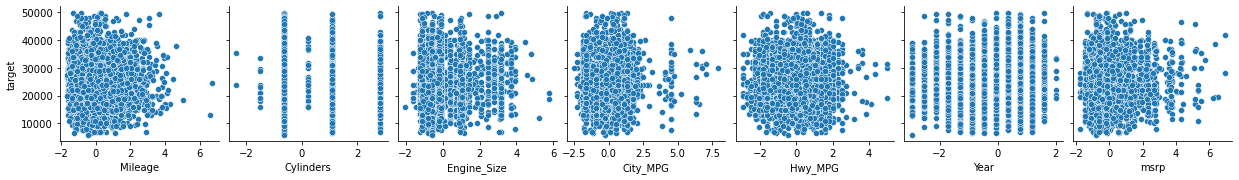

In [32]:
eda_df_sc = pd.DataFrame(X_tr, columns=X_train.columns)
eda_df_sc['target'] = y_train
sns.pairplot(eda_df_sc, y_vars=['target'], x_vars=['Mileage','Cylinders','Engine_Size','City_MPG','Hwy_MPG','Year','msrp'])

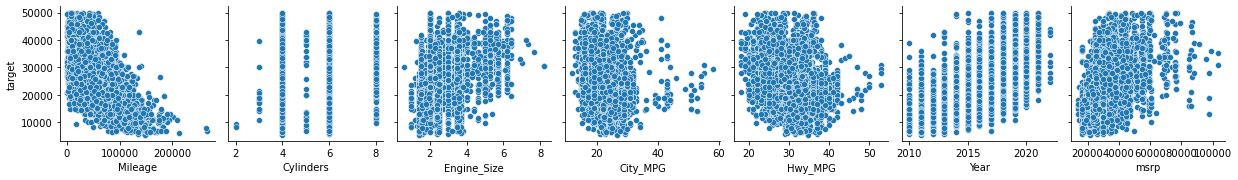

In [33]:
eda_df = X_train
eda_df['target'] = y_train
sns.pairplot(eda_df, y_vars=['target'], x_vars=['Mileage','Cylinders','Engine_Size','City_MPG','Hwy_MPG','Year','msrp'])

### Models - Regularization

In [53]:
def build_grid_search_est(model, X, y, cv=5, **params):

    grid_est = GridSearchCV(model, param_grid=params, cv=cv, 
                            return_train_score=False)
    grid_est.fit(X, y)
    df = pd.DataFrame(grid_est.cv_results_)
    for param in params:
        df[param] = df.params.apply(lambda val: val[param])
        plt.plot(df.alpha, df.mean_test_score);
    print(f'Best Alpha: {df[df.rank_test_score==1].alpha.values[0]}' )
    return grid_est

**Lasso Model**

In [347]:
model_lasso = LassoCV(alphas=np.arange(0.1,50.1,.1))
model_lasso.fit(X_tr, y_train)
model_lasso.alpha_

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


2.0

Best Alpha: 2.0


Text(0.5, 1.0, 'Grid Search for Optimal L1 Penalization')

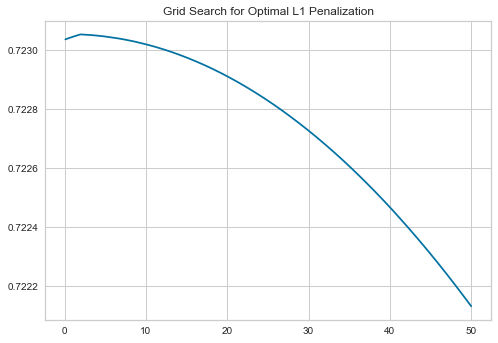

In [358]:
lasso_grid = build_grid_search_est(Lasso(), X_tr, y_train, cv=5,
                                       alpha=np.arange(0.1,50.1,.1))
plt.title('Grid Search for Optimal L1 Penalization')

**Ridge Model**

In [55]:
alphas = np.arange(0,50.1,.1)
model_ridge = RidgeCV(alphas=alphas, cv=5)
model_ridge.fit(X_tr, y_train)
model_ridge.alpha_

12.9

Best Alpha: 12.9


Text(0.5, 1.0, 'Grid Search for Optimal L2 Penalization')

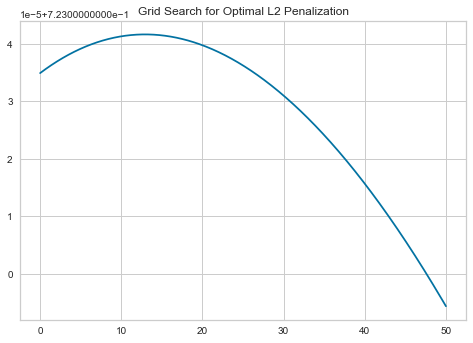

In [359]:
ridge_grid = build_grid_search_est(Ridge(), X_tr, y_train, cv=5,
                                       alpha=np.arange(0,50.1,.1))
plt.title('Grid Search for Optimal L2 Penalization')

Best Alpha: 12.9


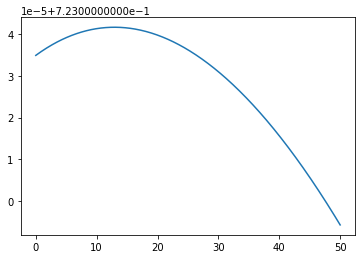

In [56]:
ridge_grid = build_grid_search_est(Ridge(), X_tr, y_train, cv=5,
                                       alpha=np.arange(0,50.1,.1))
plt.title('Grid Search for Optimal L2 Penalization')

**Elastic Net**

In [57]:
alphas = np.arange(0.1,50.1,.11)
l1_rats = np.arange(0.1,1.1,.1)
model_en = ElasticNetCV(alphas=alphas, l1_ratio=l1_rats, cv=5)
model_en.fit(X_tr, y_train.values.reshape(-1))
print(model_en.alpha_, model_en.l1_ratio_)

1.9700000000000004 1.0


**No Regularization**

In [78]:
lr_model = LinearRegression()
lr_model.fit(X_tr, y_train)

LinearRegression()

In [364]:
en_pred = model_en.predict(X_tr)
en_dict = ({'Model':'Elastic Net','Alpha':model_en.alpha_,'L1 Ratio':model_en.l1_ratio_,
            'R^2 Score':model_en.score(X_tr,y_train), 'Mean Squared Error':mean_squared_error(y_train, en_pred),
           'Mean absolute Error':mean_absolute_error(y_train, en_pred)})

lasso_pred = model_lasso.predict(X_tr)
lasso_dict = ({'Model':'Lasso','Alpha':model_lasso.alpha_, 'R^2 Score':model_lasso.score(X_tr,y_train),
            'Mean Squared Error':mean_squared_error(y_train, lasso_pred),
            'Mean absolute Error':mean_absolute_error(y_train, lasso_pred)})

ridge_pred = model_ridge.predict(X_tr)
ridge_dict = ({'Model':'Ridge','Alpha':model_ridge.alpha_,'R^2 Score':model_ridge.score(X_tr,y_train),
            'Mean Squared Error':mean_squared_error(y_train, ridge_pred),
           'Mean absolute Error':mean_absolute_error(y_train, ridge_pred)})

lr_pred = lr_model.predict(X_tr)
lr_dict = ({'Model':'Plain Linear','R^2 Score':lr_model.score(X_tr,y_train),
            'Mean Squared Error':mean_squared_error(y_train, lr_pred),
           'Mean absolute Error':mean_absolute_error(y_train, lr_pred)})

li_pred = model_li.predict(X_li)
li_dict = ({'Model':'Lasso without influential points','R^2 Score':model_li.score(X_li,y_li),
            'Mean Squared Error':mean_squared_error(y_li, li_pred),
           'Mean absolute Error':mean_absolute_error(y_li, li_pred)})

poly_pred = poly_model.predict(X_p_li)
poly_dict = ({'Model':'Polynomial','R^2 Score':poly_model.score(X_p_li, y_p_li),
            'Mean Squared Error':mean_squared_error(y_p_li, poly_pred),
           'Mean absolute Error':mean_absolute_error(y_p_li, poly_pred)})

metrics = pd.DataFrame([lr_dict, lasso_dict, ridge_dict, en_dict, li_dict, poly_dict])

In [365]:
metrics

,Model,R^2 Score,Mean Squared Error,Mean absolute Error,Alpha,L1 Ratio
0,Plain Linear,0.725275,1.837425e+07,3335.493243,NaN,NaN
1,Lasso,0.725274,1.837435e+07,3335.626194,2.00,NaN
2,Ridge,0.725271,1.837455e+07,3335.628108,12.90,NaN
3,Elastic Net,0.725274,1.837435e+07,3335.624181,1.97,1.0
4,Lasso without influential points,0.769297,1.357837e+07,2952.719570,NaN,NaN
5,Polynomial,0.796021,1.200545e+07,2713.700765,NaN,NaN


Lars Path

Computing regularization path using the LARS ...
.

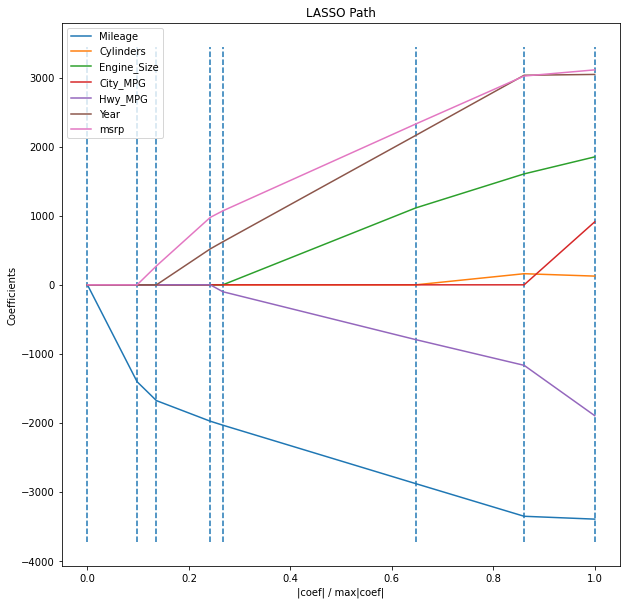

In [60]:
from sklearn.linear_model import lars_path
import matplotlib.pyplot as plt

alphas = 10**np.linspace(-2,2,200)

print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(X_tr, y_train.values.reshape(-1), method='lasso', verbose=True)

# plotting the LARS path

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(X.columns)
plt.show()

In [ ]:
plot_act_vs_pred(y_test, model_li.predict(X_te_df), scale=1000, act_label='True Values', pred_label='Prediction', 
                 figsize=(10,10), xlim=(0,45), ylim=(0,45))
plt.title('Prediction Model')

Text(0.5, 1.0, 'Prediction Model')

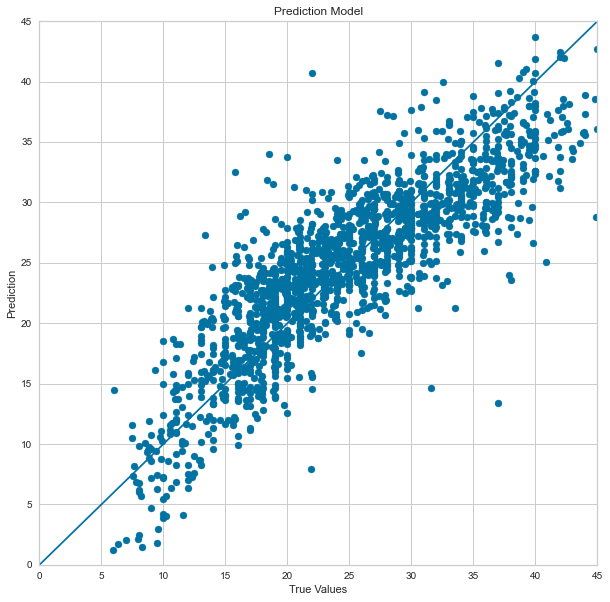

In [86]:
plot_act_vs_pred(y_test, model_lasso.predict(X_te), scale=1000, act_label='True Values', pred_label='Prediction', 
                 figsize=(10,10), xlim=(0,45), ylim=(0,45))
plt.title('Prediction Model')

### Residual Analysis

In [61]:
from yellowbrick.regressor import ResidualsPlot, CooksDistance

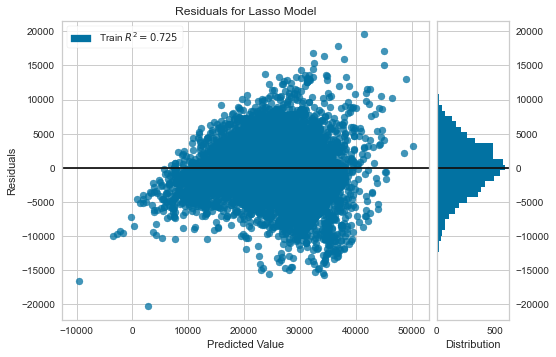

In [289]:
# Instantiate the linear model and visualizer # Insta 
model = Lasso(alpha=2)
visualizer = ResidualsPlot(model)

visualizer.fit(X_tr, y_train.values.reshape(-1))  # Fit the training data to the visualizer
#visualizer.score(X_te, y_test.values.reshape(-1))  # Evaluate the model on the test data 
g = visualizer.poof()             # Draw/show/poof the data

CooksDistance(ax=<AxesSubplot:>)

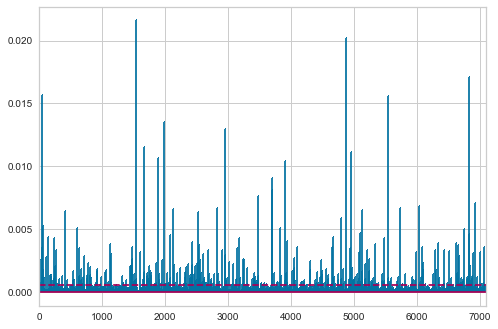

In [290]:
visualizer = CooksDistance()
visualizer.fit(X_tr, y_train.values.reshape(-1))

In [292]:
i_less_influential = (visualizer.distance_ <= visualizer.influence_threshold_)

In [293]:
X_tr.shape[0] - sum(i_less_influential)

399

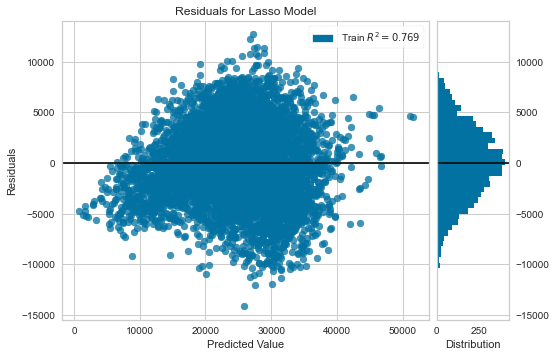

<AxesSubplot:title={'center':'Residuals for Lasso Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [294]:
i_less_influential = (visualizer.distance_ <= visualizer.influence_threshold_)
X_li, y_li = X_tr[i_less_influential], y_train[i_less_influential]

model = Lasso(alpha=2)
visualizer_residuals = ResidualsPlot(model)
visualizer_residuals.fit(X_li, y_li.Price)
visualizer_residuals.show()

[(-23000.0, 23000.0), (-10000.0, 53000.0)]

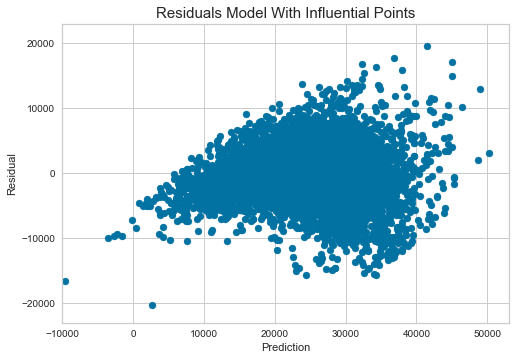

In [356]:
model_inf = Lasso(alpha=2)
model_inf.fit(X_tr, y_train)
y_pred_inf = model_inf.predict(X_tr)
fig = plt.scatter(y_pred_inf, y_pred_inf-np.array([row[0] for row in y_train.values]))
fig.axes.set_ylabel('Residual')
fig.axes.set_xlabel('Prediction')
fig.axes.set_title('Residuals Model With Influential Points', fontsize=15)
fig.axes.set(ylim=(-23000,23000), xlim=(-10000, 53000))

[(-23000.0, 23000.0), (-10000.0, 53000.0)]

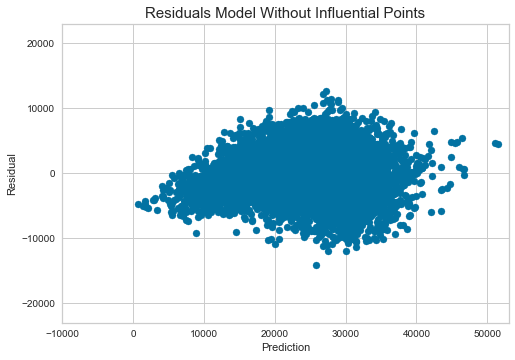

In [357]:
model_li = Lasso(alpha=2)
model_li.fit(X_li, y_li)
y_pred_li = model_li.predict(X_li)
fig = plt.scatter(y_pred_li, y_pred_li-np.array([row[0] for row in y_li.values]))
fig.axes.set_ylabel('Residual')
fig.axes.set_xlabel('Prediction')
fig.axes.set_title('Residuals Model Without Influential Points', fontsize=15)
fig.axes.set(ylim=(-23000,23000), xlim=(-10000, 53000))

0.7692966188162451


Text(0.5, 1.0, 'Penalized Linear Regression')

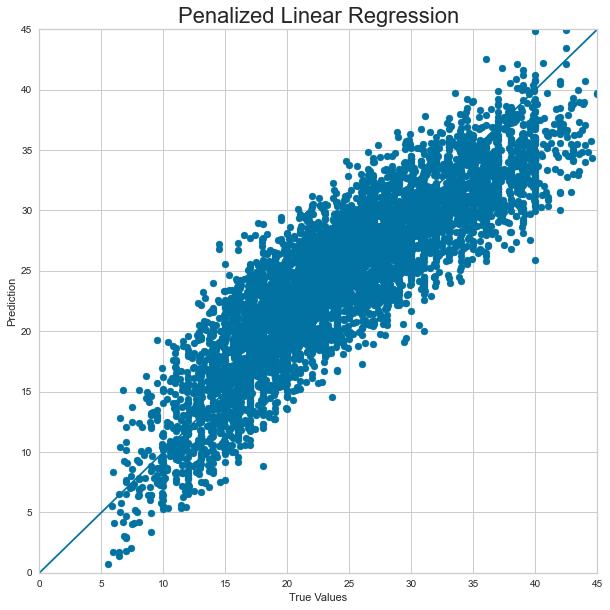

In [360]:
model_li = Lasso(alpha=2)
model_li.fit(X_li, y_li)
print(model_li.score(X_li, y_li))

plot_act_vs_pred(y_li, model_li.predict(X_li), scale=1000, act_label='True Values', pred_label='Prediction', 
                 figsize=(10,10), xlim=(0,45), ylim=(0,45))
plt.title('Penalized Linear Regression', fontsize=22)

### Polynomial Regression

In [131]:
from sklearn.preprocessing import PolynomialFeatures

In [234]:
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_feats = poly.fit_transform(X)

X_p_test, X_p_train, y_p_test, y_p_train = train_test_split(poly_feats, y, test_size=.8, random_state=22)

X_p_li, y_p_li = X_p_train[i_less_influential], y_p_train[i_less_influential]

In [361]:
poly_model = LinearRegression()
poly_model.fit(X_p_li, y_p_li)

LinearRegression()

In [345]:
poly_pred = poly_model.predict(X_p_test)
poly_dict = ({'Model':'Polynomial','R^2 Score':poly_model.score(X_p_test, y_p_test),
            'Mean Squared Error':mean_squared_error(y_p_test, poly_pred),
           'Mean absolute Error':mean_absolute_error(y_p_test, poly_pred)})
li_pred = model_li.predict(X_te)
li_dict = ({'Model':'Lasso without influential points','R^2 Score':model_li.score(X_te,y_test),
            'Mean Squared Error':mean_squared_error(y_test, li_pred),
           'Mean absolute Error':mean_absolute_error(y_test, li_pred)})
li_dict, poly_dict

({'Model': 'Lasso without influential points',
  'R^2 Score': 0.7315824741793013,
  'Mean Squared Error': 18973240.93835348,
  'Mean absolute Error': 3326.3320566150555},
 {'Model': 'Polynomial',
  'R^2 Score': 0.769893962882314,
  'Mean Squared Error': 16265172.217256524,
  'Mean absolute Error': 3016.9239335126226})

Text(0.5, 1.0, 'Polynomial Regression')

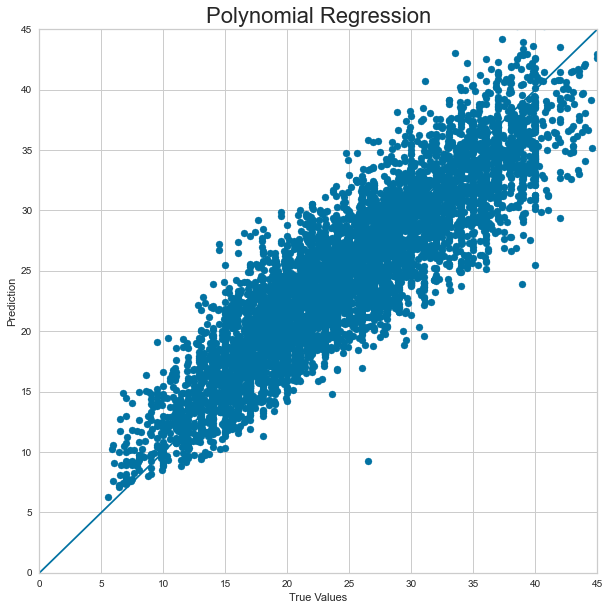

In [366]:
plot_act_vs_pred(y_p_li, poly_model.predict(X_p_li), scale=1000, act_label='True Values', pred_label='Prediction', 
                 figsize=(10,10), xlim=(0,45), ylim=(0,45))
plt.title('Polynomial Regression', fontsize=22)

## Results

Text(0.5, 1.0, 'Polynomial Regression on Test Set')

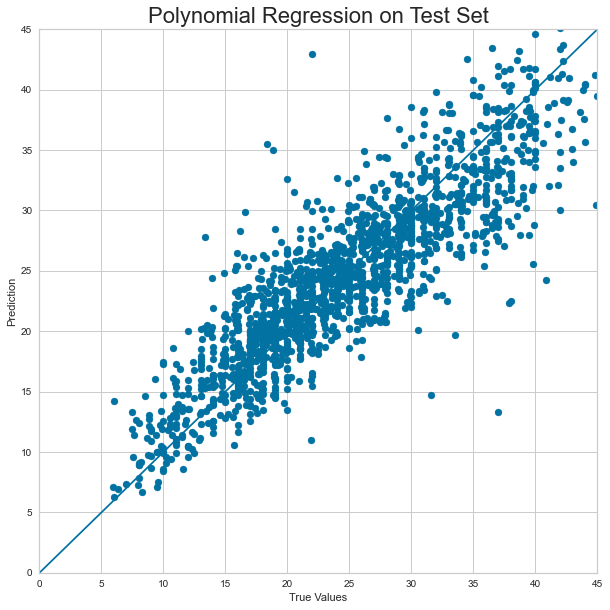

In [320]:
plot_act_vs_pred(y_p_test, poly_model.predict(X_p_test), scale=1000, act_label='True Values', pred_label='Prediction', 
                 figsize=(10,10), xlim=(0,45), ylim=(0,45))
plt.title('Polynomial Regression on Test Set', fontsize=22)

Text(0.5, 1.0, 'Regularized Linear Regression on Test Set')

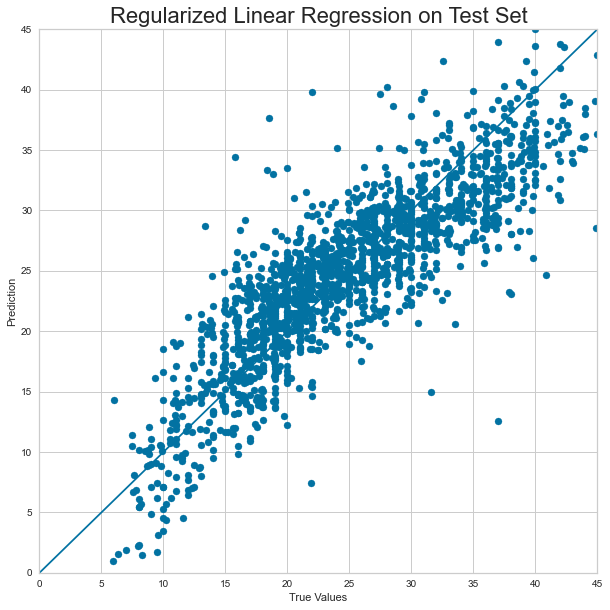

In [344]:
plot_act_vs_pred(y_test.values, model_li.predict(X_te), scale=1000, act_label='True Values', pred_label='Prediction', 
                 figsize=(10,10), xlim=(0,45), ylim=(0,45))
plt.title('Regularized Linear Regression on Test Set', fontsize=22)

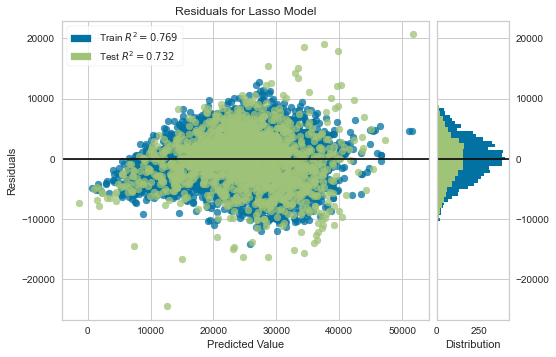

<AxesSubplot:title={'center':'Residuals for Lasso Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [353]:
model = Lasso(alpha=2)
visualizer = ResidualsPlot(model)

visualizer.fit(X_li, y_li.values.reshape(-1))  # Fit the training data to the visualizer
visualizer.score(X_te, y_test.values.reshape(-1))  # Evaluate the model on the test data
visualizer.show()  

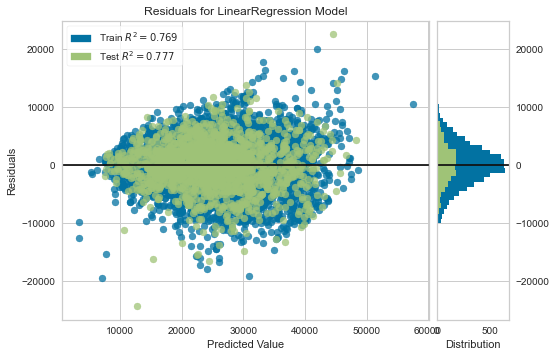

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [355]:
model = LinearRegression()
visualizer = ResidualsPlot(model)

visualizer.fit(X_p_train, y_p_train)  # Fit the training data to the visualizer
visualizer.score(X_p_test, y_p_test)  # Evaluate the model on the test data
visualizer.show()

## With Categorical Features

In [217]:
X_te_cat, X_tr_cat = X_test.copy(deep=True), X_train.copy(deep=True)
X_te_cat.iloc[:,:7], X_tr_cat.iloc[:,:7] = X_te, X_tr

In [218]:
model_lasso = LassoCV(alphas=np.arange(0.1,50.1,.1))
model_lasso.fit(X_tr_cat, y_train)
model_lasso.alpha_

/opt/anaconda3/envs/linreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:1572: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1.9000000000000001

Best Alpha: 2.0


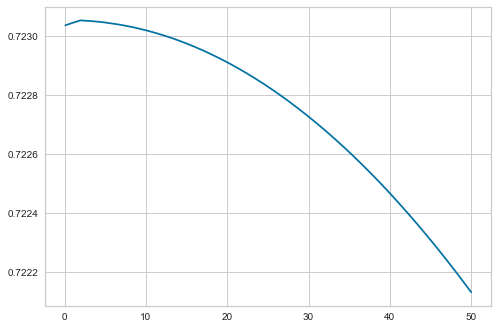

In [219]:
lasso_grid = build_grid_search_est(Lasso(), X_tr, y_train, cv=5,
                                       alpha=np.arange(0.1,50.1,.1))

In [227]:
model_cat_linear = LinearRegression()
model_cat_linear.fit(X_tr_cat, y_train)

LinearRegression()

In [220]:
lasso_grid.best_score_

0.7230525667252234

In [221]:
model_lasso.coef_

array([-3282.47497164,   356.76013801,  1587.4554271 ,   728.07828397,
       -1147.35994854,  3129.50064386,  3055.10872737,   545.02797464,
        2210.24642973,  1377.21924535,   521.11764675, -1874.91024666,
          -0.        ,  1811.91046659,     0.        , -2137.88845964,
        -877.41619954,    45.87549433, -2506.79134937])

In [222]:
X_train.columns

Index(['Mileage', 'Cylinders', 'Engine_Size', 'City_MPG', 'Hwy_MPG', 'Year',
       'msrp', 'Transmission_manual', 'Drivetrain_4X4',
       'Body Style_convertible', 'Body Style_coupe', 'Body Style_hatchback',
       'Body Style_minivan', 'Body Style_pickup', 'Body Style_pickup_truck',
       'Body Style_sedan', 'Body Style_suv', 'Body Style_van',
       'Body Style_wagon'],
      dtype='object')

#### Shap plot

In [224]:
import shap

In [396]:
model_lasso = Lasso(alpha=2)
model_lasso.fit(X_tr_cat, y_train)

Lasso(alpha=2)

In [394]:
X_tr_cat['MPG'] = X_tr_cat.Hwy_MPG + X_tr_cat.City_MPG / 2
X_te_cat['MPG'] = X_te_cat.Hwy_MPG + X_te_cat.City_MPG / 2
X_te_cat.drop(columns=['Hwy_MPG', 'City_MPG'], inplace=True)
X_tr_cat.drop(columns=['Hwy_MPG', 'City_MPG'], inplace=True)

In [395]:
X_tr_cat.head()

,Mileage,Cylinders,Engine_Size,Year,msrp,Transmission_manual,Drivetrain_4X4,Body Style_convertible,Body Style_coupe,Body Style_hatchback,Body Style_minivan,Body Style_pickup,Body Style_pickup_truck,Body Style_sedan,Body Style_suv,Body Style_van,Body Style_wagon,MPG
1358,-1.302952,-0.631441,-0.085482,0.344815,-1.058704,1,0,0,0,1,0,0,0,0,0,0,0,0.296319
1232,-0.530146,1.103066,0.733322,-0.483442,-0.203663,0,0,0,0,0,0,0,0,0,1,0,0,-0.792208
7143,-0.759433,1.103066,1.040374,1.173072,0.203545,0,0,0,0,0,0,0,0,0,1,0,0,-1.493674
7567,0.687632,1.103066,1.040374,-0.483442,0.203062,0,0,0,0,0,0,0,0,0,1,0,0,-0.685796
7690,-0.283078,-0.631441,-1.006637,-1.725827,-0.814959,0,0,0,0,0,0,0,0,1,0,0,0,0.083543


Permutation explainer: 1775it [01:50, 14.49it/s]                                


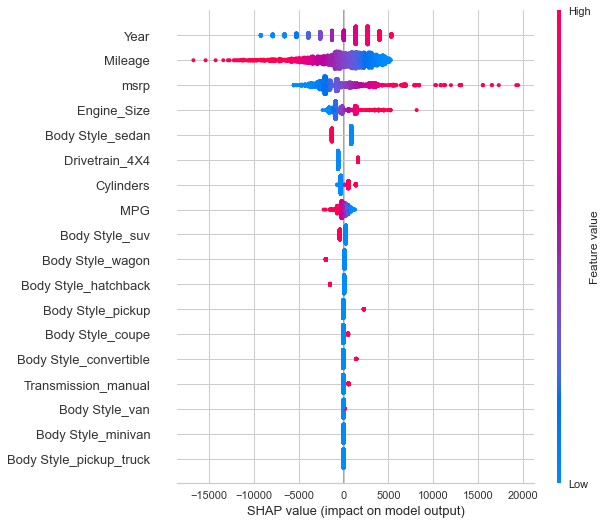

In [397]:
explainer = shap.Explainer(model_lasso.predict, X_tr_cat)
shap_test = explainer(X_te_cat)

shap.summary_plot(shap_test)

In [387]:
?shap_test.values.shape

In [ ]:
#Get SHAP values from a basic regression
model = LinearRegression()
model.fit(X_train, y_train)

explainer = shap.Explainer(model.predict, X_train)
shap_test = explainer(X_test)

shap.summary_plot(shap_test)